<a href="https://colab.research.google.com/github/MudSnail/Land_Cover_Classification/blob/main/Randomized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rastertodataframe
!pip install pyproj
!pip install geopandas

In [2]:
#import
import numpy as np
import pandas as pd

#system packages
import os
import glob

#spatial packages
from rastertodataframe import raster_to_dataframe
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

#processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn import cluster

#modeling

from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Model metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#misc
from math import floor
from itertools import product
from copy import deepcopy

In [3]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#--EVALUATION--
def get_scores(model, x, y):
  """
  Input: model, x = X_test variable, y = y_test variable
  Output: The scores and classification report for the model
  """
  #Predict X_test
  y_prediction = model.predict(x)

  #Print measure scores
  print(f"Accuracy: {accuracy_score(y, y_prediction)}")
  print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_prediction)}")
  print(f"F1 Score: {f1_score(y, y_prediction, average='micro')}")
  print(f"Precision Score: {precision_score(y, y_prediction, average='micro')}")
  print(f"Recall Score: {recall_score(y, y_prediction, average='micro')}")
  print(f"ROC AUC Score: {roc_auc_score(y, model.predict_proba(x),multi_class='ovr', average='macro')}")

  #print full classification report
  print(classification_report(y, y_prediction))

def create_class_matrix(model, x, y):
  """
  Input: model, x = X_test variable, y = y_test variable
  Output: A confusion matrix plot with all class labels
  """
  #Predict X_test
  y_prediction = model.predict(x)

  #Create a confusion matrix
  matrix = confusion_matrix(y, y_prediction)

  #Visualize the matrix with Seaborn

  #Write title to display accuracy score
  score = balanced_accuracy_score(y, y_prediction)
  all_sample_title = 'RF Accuracy Score: {0}%'.format(round(score,3)*100)

  #Set figure shape
  plt.figure(figsize=(9,9))

  #Use heatmap
  p = sns.heatmap(matrix, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap="mako")

  #Label the plot
  label = [1,2,5,6,8,10,11,12,13,14,15,16,17,18,19]
  p.set_ylabel('Actual Label', size=16)
  p.set_xlabel('Predicted Label', size = 16)
  p.set_xticklabels(label)
  p.set_yticklabels(label)
  p.set_title(all_sample_title, size = 18)

def print_importance(model, x):
    """
    Input: Model and X prior to split]
    Output: Series of feature importance coefficients in descending order
    """
    feature_importances = pd.DataFrame(model.feature_importances_, index = x.columns, columns = ['importance']).sort_values('importance', ascending = False)
    print(feature_importances)

In [5]:
#load raws into dataframe
# version10 = pd.read_csv('/content/drive/MyDrive/AISC/version10.csv')
version13 = pd.read_csv('/content/drive/MyDrive/AISC/version13.csv')

#Drop class 0
# version10 = version10[version10.y != 0]
version13 = version13[version13.y != 0]

#Subsample 45000
# version10 = version10.groupby('y').apply(lambda x: x.sample(n=45000)).reset_index(drop=True)

In [6]:
#Check number of pixels per class in version13
version13.y.value_counts()

1     80000
2     80000
5     80000
6     80000
8     80000
10    80000
11    80000
12    80000
13    80000
14    80000
15    80000
16    80000
17    80000
18    80000
19    49493
Name: y, dtype: int64

In [8]:
#Drop lowest features on importance
version13 = version13.drop(['clusters', 'B03', 'B06', 'B07', 'B09', 'B11', 'B08', 'B8Ag', 'B09g'], axis = 1)

#print columns
print(version13.columns)

Index(['B01', 'B02', 'B04', 'B05', 'B12', 'B8A', 'y', 'B01g', 'B02g', 'B03g',
       'B04g', 'B05g', 'B06g', 'B07g', 'B08g', 'B11g', 'B12g', 'NDVI',
       'Moisture', 'NDWI', 'NDSI'],
      dtype='object')


In [9]:
#Split Data
y = version13.y
X = version13.drop('y', axis = 1)

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

In [10]:
#Instantiate and Fit Model
model = RandomForestClassifier(random_state=123).fit(X_train, y_train)

Accuracy: 0.6718156127217303
Balanced Accuracy: 0.6746679058490758
F1 Score: 0.6718156127217303
Precision Score: 0.6718156127217303
Recall Score: 0.6718156127217303
ROC AUC Score: 0.9632122204627189
              precision    recall  f1-score   support

           1       0.65      0.59      0.62     16000
           2       0.65      0.66      0.65     16000
           5       0.58      0.52      0.55     16000
           6       0.60      0.66      0.63     16000
           8       0.60      0.60      0.60     16000
          10       0.64      0.66      0.65     16000
          11       0.75      0.84      0.79     16000
          12       0.59      0.49      0.54     16000
          13       0.66      0.72      0.69     16000
          14       0.72      0.75      0.73     16000
          15       0.68      0.76      0.72     16000
          16       0.62      0.43      0.51     16000
          17       0.72      0.77      0.74     16000
          18       0.92      0.88      0.90 

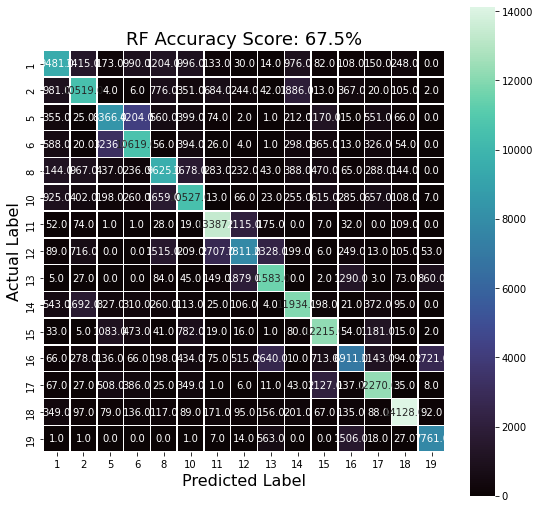

In [11]:
#Get Scores and Matrix
get_scores(model, X_test, y_test)

create_class_matrix(model, X_test, y_test)

In [12]:
#Find Feature Importance
print_importance(model, X)

          importance
NDVI        0.064064
NDWI        0.063551
NDSI        0.057271
B08g        0.056936
B07g        0.054721
B02g        0.054577
B12         0.053191
B06g        0.052021
B04g        0.051860
B12g        0.049279
B03g        0.046572
B11g        0.046336
B8A         0.045909
B01g        0.045556
B04         0.044843
B02         0.043577
B01         0.043335
B05         0.043245
B05g        0.041772
Moisture    0.041384


In [14]:
#Define grid search params
param_grid = [{'n_estimators': [100,200,300,400],
                'min_samples_leaf': [1,2,3,4],
                'max_depth': [5,6,7,8],
                'min_samples_split':[2,3,4]}]

#Run grid search
rfc_gs = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'accuracy', cv = 3)

#Fit training data
rfc_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=123),
                   param_distributions=[{'max_depth': [5, 6, 7, 8],
                                         'min_samples_leaf': [1, 2, 3, 4],
                                         'min_samples_split': [2, 3, 4],
                                         'n_estimators': [100, 200, 300, 400]}],
                   scoring='accuracy')

In [15]:
#Best Params
print(f'Score: {rfc_gs.score(X_test,y_test)}')
print(f'Best Params: {rfc_gs.best_params_}')
print(f'Best Estimator: {rfc_gs.best_estimator_}')

Score: 0.572050329415688
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 8}
Best Estimator: RandomForestClassifier(max_depth=8, min_samples_leaf=2, n_estimators=200,
                       random_state=123)


Accuracy: 0.572050329415688
Balanced Accuracy: 0.5774721234468126
F1 Score: 0.572050329415688
Precision Score: 0.572050329415688
Recall Score: 0.572050329415688
ROC AUC Score: 0.9387593517032172
              precision    recall  f1-score   support

           1       0.52      0.56      0.54     16000
           2       0.57      0.60      0.59     16000
           5       0.50      0.39      0.44     16000
           6       0.55      0.58      0.56     16000
           8       0.44      0.56      0.49     16000
          10       0.56      0.28      0.37     16000
          11       0.67      0.79      0.72     16000
          12       0.52      0.35      0.42     16000
          13       0.58      0.67      0.62     16000
          14       0.51      0.49      0.50     16000
          15       0.46      0.70      0.56     16000
          16       0.56      0.36      0.44     16000
          17       0.66      0.69      0.68     16000
          18       0.94      0.86      0.90     

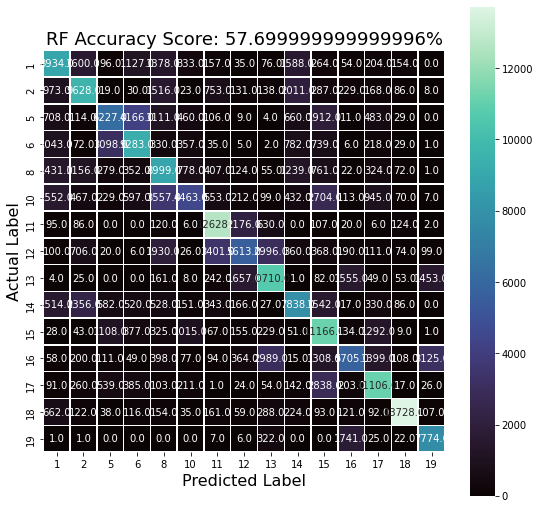

In [16]:
#Get Scores and Matrix
get_scores(rfc_gs, X_test, y_test)

create_class_matrix(rfc_gs, X_test, y_test)